In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from datetime import datetime
from geopy import distance
from sklearn.preprocessing import OneHotEncoder
import json

import src.features_penguins as ftpen
##

--> use track_id (see documentation, bird_id not unique)

In [8]:
path = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/datasets_penguins'

df = ftpen.load_penguins(path)                             # Load data into one frame
df = ftpen.date_formatting(df)                             # Resolve date formatting issues

# Delete duplicates
df = df.drop_duplicates(subset=['track_id', 'datetime']).reset_index(drop=True)
df = df.sort_values(['track_id', 'datetime']).reset_index(drop=True)

In [9]:
# investigate difference between breed status and breed stage
print(df['breed_status'].nunique())
print(df['breed_stage'].unique())

In [ ]:
# breed_status is redundant and dropped
df = df.drop(columns='breed_status')

## Features

In [17]:
df = ftpen.geodesic_distance(df)                                       # Calculate geodesic distance to colony (WGS-84 ellipsoid)
mean_distance, std_distance = ftpen.mean_distance(df)                  # mean distance between consecutive points 
df = ftpen.calculate_relative_position(df)                             # Relative position of individual penguin to colony
df = ftpen.direction_of_travel(df)                                     # Direction of travel of individual penguin (relative to last point)
df = ftpen.distance_since_last_measure(df)                             # Distance travelled since last measure
df = ftpen.distance_direction(df)                                      # Distance in NSWE direction since last measure
df = ftpen.time_difference(df)                                         # Time between measures

In [ ]:
# save df to csv and store in zip file
path_new = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/projectP/data'
ftpen.save_df(df, path_new, 'penguins_cleaned.csv')

In [ ]:
df_penguins_final = ftpen.average_per_day(df)                       # Calculate average values per day and track_id
ftpen.save_df(df_penguins_final, path_new, 'penguins_final.csv')

In [ ]:
path_json = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/projectP/era5_datasets'
ftpen.save_to_json(df_penguins_final, path_json, 'unique_dates_dict.json')

## BIN

In [ ]:
"""
# Plot coordinates of different species per month (no matter the year)

df['month'] = df['date_gmt'].str.split('/').str[1]
df['month'] = df['month'].astype(int)
# create one plot per species, with moth on x-axis and latitude on y-axis and one per species with month on x-axis and longitude on y-axis
species = df['common_name'].unique()

months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']


for specie in species:
    df_specie = df[df['common_name'] == specie]
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.boxplot(x='month', y='latitude', data=df_specie, ax=ax[0])
    ax[0].set_title('Latitude per month for ' + specie)
    sns.boxplot(x='month', y='longitude', data=df_specie, ax=ax[1])
    ax[1].set_title('Longitude per month for ' + specie)
    plt.tight_layout()
    plt.show()
"""

In [35]:
"""
titles = {'siconc': 'Sea Ice Concentration', 'rsn': 'Snow Density', 'sst': 'Sea Surface Temperature', 'sd': 'Snow Depth', 't2m': '2m Temperature', 'tp': 'Total Precipitation', 'avg_smr': 'Average Snowmelt Rate'}

column = df['km_to_colony']

def plot_monthly(df, column, deg):
    df = df.copy()
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    # only keep values from years 1996, 2000, 2004, 2008, 2012, 2016
    df = df[df['year'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])]

    plt.figure(figsize=(12, 3))
    
    # for each column, use only rows that dont have zero values
    df = df[df[column] != 0]

    #scatter = plt.scatter(df['month'], df[column], c = 'black')
    scatter = plt.scatter(df['month'], df[column], 
                        c=df['year'], cmap='viridis')

    # Add colorbar
    plt.colorbar(scatter, label='Year')

    plt.xlabel('month')
    #plt.title(title)
    plt.tight_layout()
    plt.show()
"""

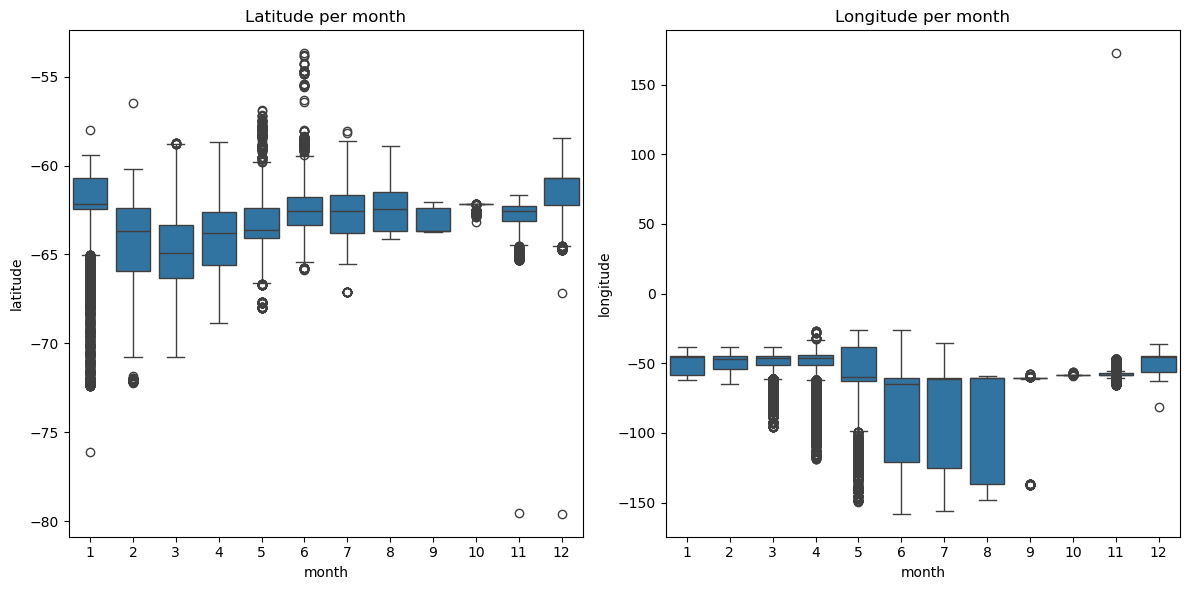

In [37]:
"""
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x='month', y='latitude', data=df, ax=ax[0])
ax[0].set_title('Latitude per month')
sns.boxplot(x='month', y='longitude', data=df, ax=ax[1])
ax[1].set_title('Longitude per month')
plt.tight_layout()
plt.show()
"""

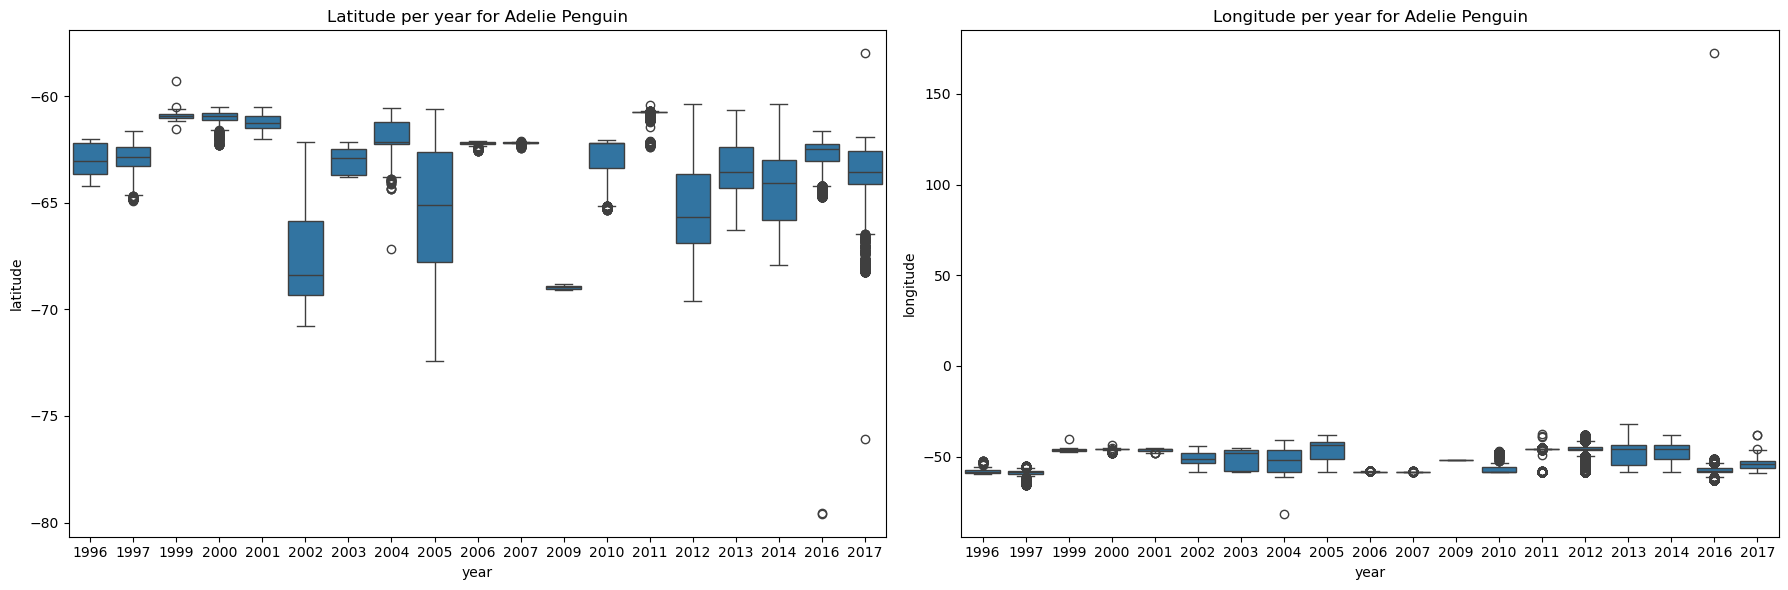

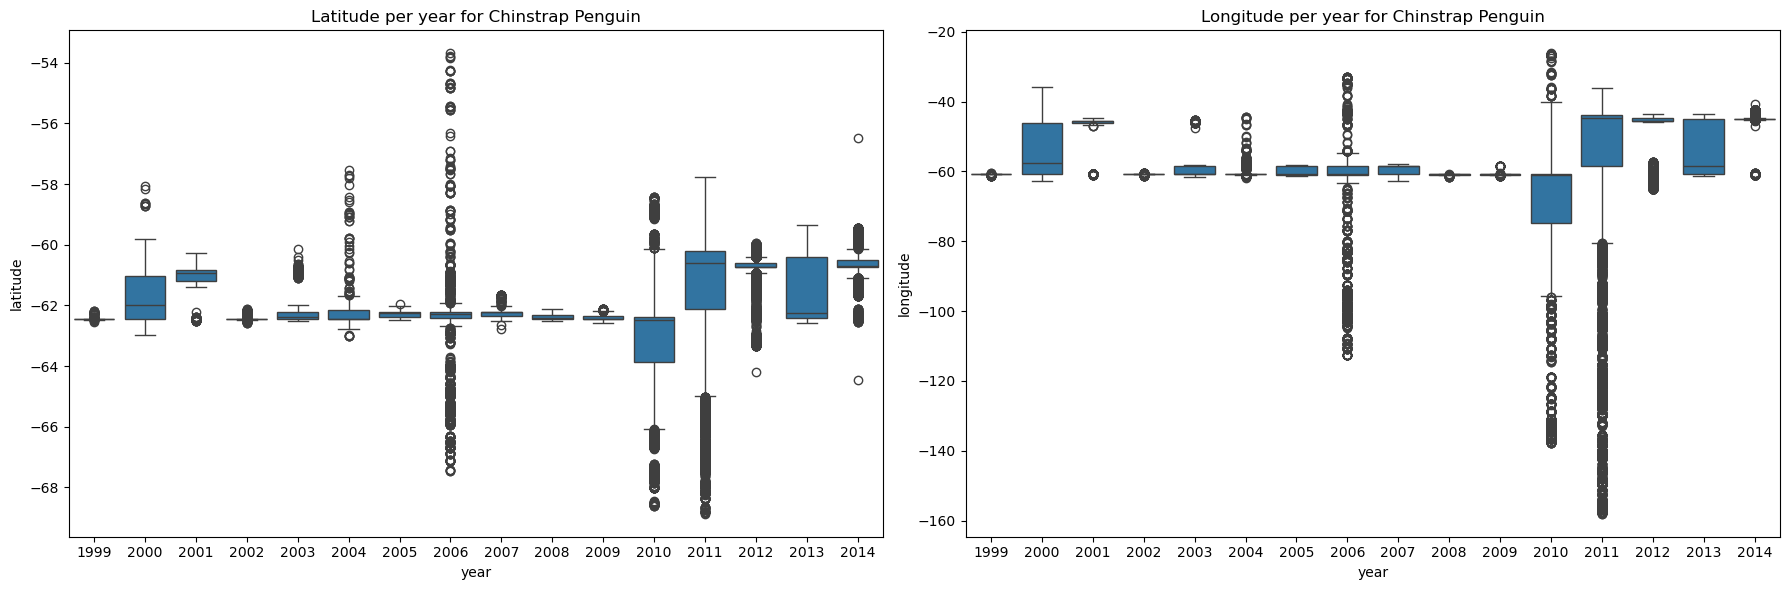

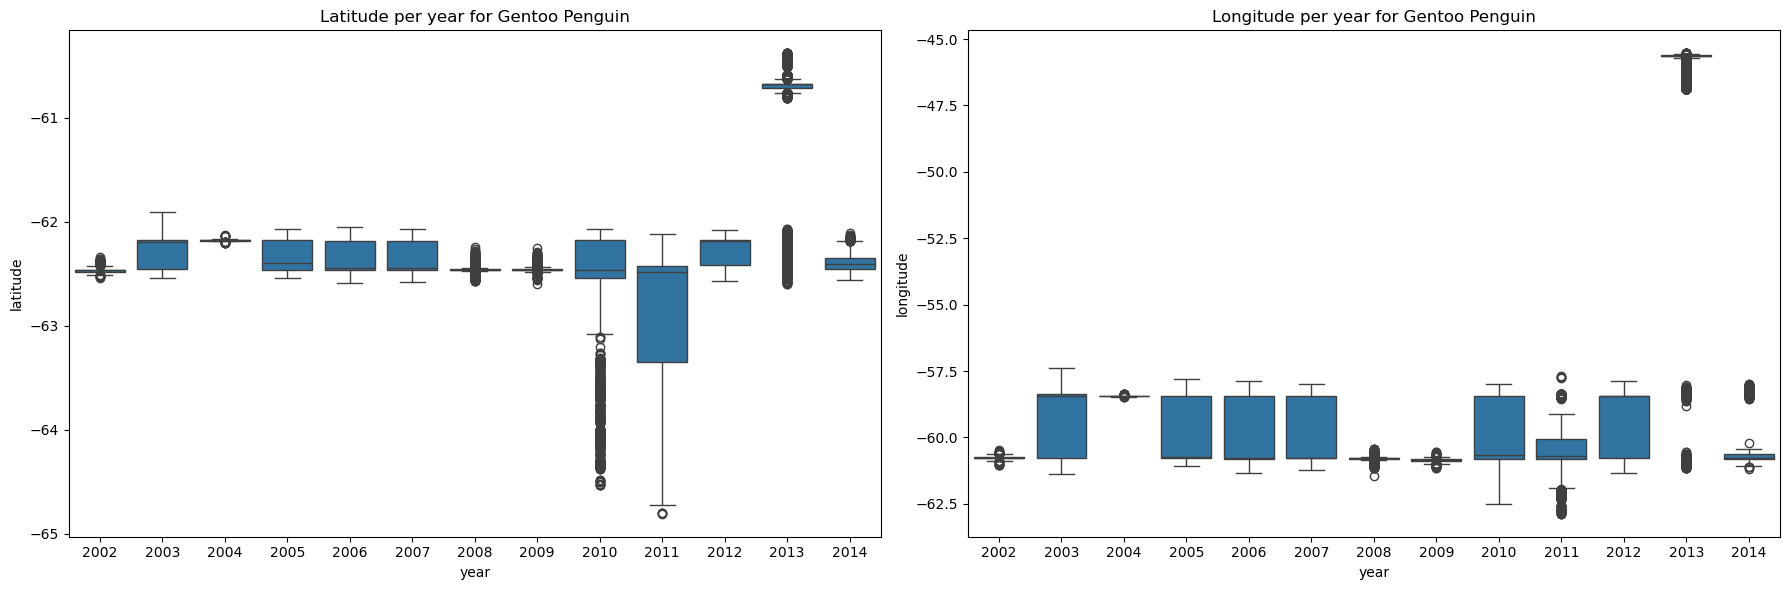

In [38]:
"""
df['year'] = df['date_gmt'].str.split('/').str[2]
df['year'] = df['year'].astype(int)

for specie in species:
    df_specie = df[df['common_name'] == specie]
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    sns.boxplot(x='year', y='latitude', data=df_specie, ax=ax[0])
    ax[0].set_title('Latitude per year for ' + specie)
    sns.boxplot(x='year', y='longitude', data=df_specie, ax=ax[1])
    ax[1].set_title('Longitude per year for ' + specie)
    plt.tight_layout()
    plt.show()
"""

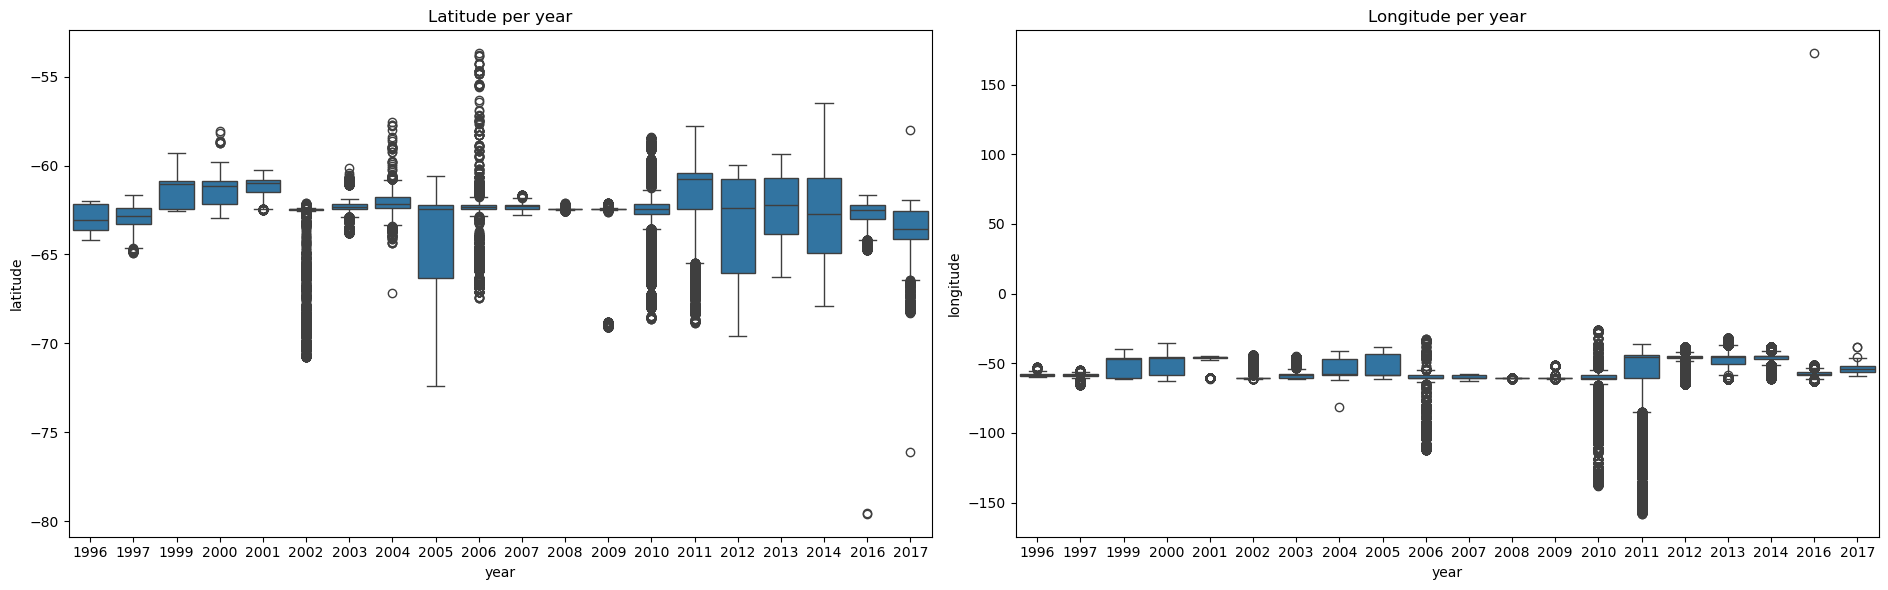

In [39]:
"""
# plots in general
fig, ax = plt.subplots(1, 2, figsize = (19, 6))
sns.boxplot(x='year', y='latitude', data = df, ax=ax[0])
ax[0].set_title('Latitude per year')
sns.boxplot(x='year', y='longitude', data = df, ax=ax[1])
ax[1].set_title('Longitude per year')
plt.tight_layout()
plt.show()
"""

In [41]:

"""
# One Hot Encoding: 
categorical_cols = ['breed_stage', 'relative_position', 'direction_of_travel']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categorical_cols])

one_hot_df = pd.DataFrame(one_hot_encoded, columns = encoder.get_feature_names_out(categorical_cols))

df_encoded = pd.concat([df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_cols, axis=1)

df = df_encoded
"""

# Get insights into the penguins behaviour

In [ ]:
species = df['common_name'].unique()

ftpen.spread_species(df_penguins_final, species)            # standard deviation of penguins distance to colony

In [53]:
ftpen.calculte_mean_deviation(df_penguins_final)            # mean deviation to colony per specie and colony

Adelie Penguin
King George Island 129.4704820208191
Hope Bay 164.31657218913702
Powell Island/Peng colony 188.5177415557273
Signy Island/Gourlay 200.64823394539997
Signy Island/North Point 340.630021992136
Admiralty Bay 187.6252134675522
Chinstrap Penguin
Laurie Island/Cape Geddes 19.193426327121703
Signy Island/Gourlay 12.324104237789548
Powell Island/Peng colony 12.005098504707792
Admiralty Bay 96.47090182991843
Cape Shirreff 571.9082535242949
Gentoo Penguin
Signy Island/North Point 8.846322623042843
Admiralty Bay 6.105893753653458
Cape Shirreff 32.132810331351685


# do it in time series perspective (NEEDED?? probably just add to bin)


In [55]:
# add year back for calculation
# extract each unique combination of year, month and day in a dictionary
"""
unique_dates = df_penguins_final['date_gmt'].unique()
for date in unique_dates:
    year = date.split('-')[0]
    df_penguins_final.loc[df_penguins_final['date_gmt'] == date, 'year'] = year
df_penguins_final = df_penguins_final.sort_values('year').reset_index(drop=True)
"""

In [56]:
"""
# print number of oberverations per year and species
species = df_penguins_final['common_name'].unique()
years = df_penguins_final['year'].unique()
for specie in species:
    for year in years:
        print(specie, f'{year}:', len(df_penguins_final[(df_penguins_final['common_name'] == specie) & (df_penguins_final['year'] == year)]))
"""

Adelie Penguin 1996: 46
Adelie Penguin 1997: 198
Adelie Penguin 1999: 34
Adelie Penguin 2000: 75
Adelie Penguin 2001: 19
Adelie Penguin 2002: 77
Adelie Penguin 2003: 69
Adelie Penguin 2004: 212
Adelie Penguin 2005: 295
Adelie Penguin 2006: 41
Adelie Penguin 2007: 19
Adelie Penguin 2008: 0
Adelie Penguin 2009: 10
Adelie Penguin 2010: 122
Adelie Penguin 2011: 44
Adelie Penguin 2012: 1081
Adelie Penguin 2013: 720
Adelie Penguin 2014: 766
Adelie Penguin 2016: 1265
Adelie Penguin 2017: 937
Chinstrap Penguin 1996: 0
Chinstrap Penguin 1997: 0
Chinstrap Penguin 1999: 46
Chinstrap Penguin 2000: 273
Chinstrap Penguin 2001: 121
Chinstrap Penguin 2002: 155
Chinstrap Penguin 2003: 177
Chinstrap Penguin 2004: 133
Chinstrap Penguin 2005: 124
Chinstrap Penguin 2006: 495
Chinstrap Penguin 2007: 226
Chinstrap Penguin 2008: 64
Chinstrap Penguin 2009: 155
Chinstrap Penguin 2010: 503
Chinstrap Penguin 2011: 839
Chinstrap Penguin 2012: 465
Chinstrap Penguin 2013: 147
Chinstrap Penguin 2014: 413
Chinstrap Pe

Could be beneficial to filter out years with less than 30 obs.
Also for interpretability, from 2012 on,  it is mainly adelie penguins

# THIS NEEDS DISCUSSION TOMORROW

In [57]:
"""
# filter out years with less than 30 observations?
df_penguins_final = df_penguins_final.groupby(['year', 'colony_name']).filter(lambda x: len(x) > 30).reset_index(drop=True)

# filter out obeservations with more than 1 day between measures
df_penguins_final = df_penguins_final[df_penguins_final['minutes_since_last_measure_mean'] <= 1440].reset_index(drop=True)
"""

In [ ]:
mean_deviation_colony_df = ftpen.mean_deviation_colony(df, df_penguins_final)           # Mean deviation on a yearly level

In [ ]:
# availability check (if needed)
ftpen.check_availability(df_penguins_final, 5)

NameError: name 'df_penguins_final' is not defined

## Some more EDA

In [ ]:
species = df['common_name'].unique()
ftpen.plot_yearly_species(df, 4, species)

NameError: name 'plot_yearly_species' is not defined

- Chinstrap and Gentoo penguins show pretty similar patterns, adelie is only species where we would confidently say that the patterns are going up (specieswise)
- the 2010/2011 peak is from the cape shirreff colonies 

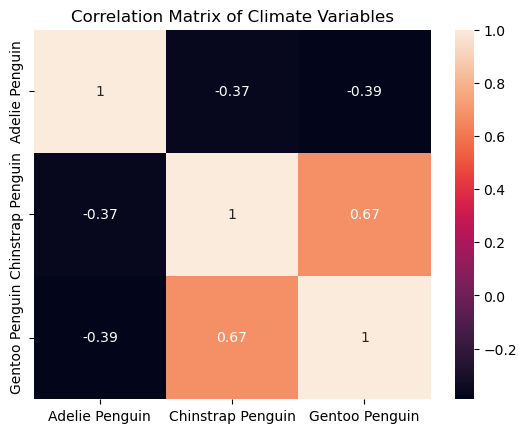

In [138]:
# correlations of species/years
species = df['common_name'].unique()
years = sorted(df['year'].unique())

df_new = pd.DataFrame()
df_new['year'] = years

df_new = pd.DataFrame({'year': years})  # Initialize with year column

for sp in species:
    grouped_data = df[df['common_name'] == sp].groupby('year')['km_to_colony'].mean()
    df_new[sp] = df_new['year'].map(grouped_data)

correlation_matrix = df_new[species].corr()

sns.heatmap(correlation_matrix, annot=True)
plt.title(f'Correlation Matrix of penguin travel pattern')
plt.show()

In [214]:
"""
# check which years with adelie penguins have more than 100 days of data
df_adelie = df[df['common_name'] == 'Adelie Penguin']
years = sorted(df_adelie['year'].unique())

# group by day
df_adelie = df_adelie.groupby(['year', 'month', 'day']).mean().reset_index()

print(df_adelie['year'].value_counts())
"""

2013    143
2012    134
2014    113
2004    103
2016     56
2005     56
2003     53
1997     45
2017     44
2010     42
2002     34
2000     29
1996     25
1999     18
2011     11
2009     10
2001     10
2006     10
2007      4
Name: year, dtype: int64


/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_11747/2414832450.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_adelie = df_adelie.groupby(['year', 'month', 'day']).mean().reset_index()
